# Real-time predictions of Dota match outcome

#### In this notebook we are going to present a simple real-time prediction on a particular window of 5-minutes.
#### The notebook contains

* Some 
Logistic regression

### Library Imports

In [125]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, plot_roc_curve, roc_auc_score

# interactive viz
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [164]:
plt.style.use('default')

### Data Imports

In [154]:
time_df = pd.read_csv('../data/player_time.csv')
matches_df = pd.read_csv("../data/match.csv")
player_df = pd.read_csv("../data/players.csv")

matches_df.set_index('match_id');

### Helper methods

In [10]:
# todo: move those in a separate module

RAD_GLD_COLS = [f'gold_t_{i}' for i in range(0, 5)]
DIR_GLD_COLS = [f'gold_t_{i}' for i in range(128, 133)]

RAD_XP_COLS = [f'xp_t_{i}' for i in range(0, 5)]
DIR_XP_COLS = [f'xp_t_{i}' for i in range(128, 133)]

def get_mean_gold_difference(df):
    return df[RAD_GLD_COLS].mean(axis=1) - df[DIR_GLD_COLS].mean(axis=1)

def get_mean_xp_difference(df):
    return df[RAD_XP_COLS].mean(axis=1) - df[DIR_XP_COLS].mean(axis=1)

### Data Preprocessing

In [123]:
time_df['mean_gold_diff'] = get_mean_gold_difference(time_df)
time_df['mean_xp_diff'] = get_mean_xp_difference(time_df)

# set time and join with radiant win
time_df['times'] = pd.to_datetime(time_df['times'], unit='s') # turn the seconds to real time
gold_diff_df = time_df.pivot(index='match_id', columns='times', values='mean_gold_diff')
xp_diff_df = time_df.pivot(index='match_id', columns='times', values= 'mean_xp_diff')

# standardize the data
std_scaler = StandardScaler()
gold_diff_std_df = pd.DataFrame(std_scaler.fit_transform(gold_diff_df), columns=gold_diff_df.columns)
xp_diff_std_df = pd.DataFrame(std_scaler.fit_transform(xp_diff_df), columns=gold_diff_df.columns)


### Explore correlation between mean gold difference and mean xp difference of the teams

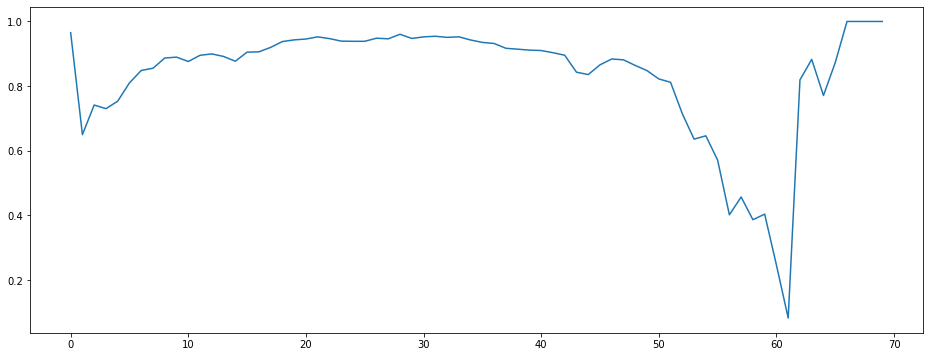

In [126]:
figure = plt.figure(figsize=(16, 6))

gold_xp_time_correlations = match_time_gold_difference_df.corrwith(match_time_xp_difference_df[1:60], drop=True)
sns.lineplot(x=gold_xp_time_correlations.index, y=gold_xp_time_correlations);

#### We see high correlation between the mean gold difference and the mean xp difference which should mean that only one of the predictors should be enough for fitting a model

### Data Exploration on a particular match

In [12]:
@widgets.interact()
def show_match(match=(1, 50)):

    plt.figure(figsize=(20, 6))
    plt.grid(True)

    some_match = time_df[time_df['match_id'] == match]
    does_win = matches_df.at[match, 'radiant_win']
    winner = 'Radiant' if does_win else 'Dire'

    g1 = sns.lineplot(data=some_match, y='mean_gold_diff', x='times', label='Teams Mean Gold Different')
    g2 = sns.lineplot(data=some_match, y='mean_xp_diff', x='times', label='Teams Mean Experience Different')

    date_form = DateFormatter("%M")
    g1.xaxis.set_major_formatter(date_form)

    x_label = f'minutes \ {winner} wins'

    g1.set(xlabel=x_label, ylabel='Radiant \ Dire Gold and Experience Difference');
    return match

interactive(children=(IntSlider(value=25, description='match', max=50, min=1), Output()), _dom_classes=('widge…

## Explore the predictors on a particular minute

### Distribution plot on the gold difference at a particular minute

In [138]:
@widgets.interact()
def plot_mean_gold_difference(minute = (1, 60)):
    sns.distplot(gold_diff_std_df.iloc[:, minute])
    return minute

interactive(children=(IntSlider(value=30, description='minute', max=60, min=1), Output()), _dom_classes=('widg…

Looks like the gold follows a Student's  t-distribution.

## Logistic regression on a time window of 5 minutes

In [80]:
def train(X_train, y_train, minute, model = LogisticRegression()):
    ncols = X_train.shape[1]
    start = max(0, minute - 6)
    end = min(ncols - 1, minute - 1)

    is_present = -X_train.iloc[:, start:end].isna().any(axis=1)

    return model.fit(X_train[is_present].iloc[:, start:end], y_train[is_present])

In [139]:
outcome = matches_df['radiant_win']
X_train, X_test, y_train, y_test = train_test_split(gold_diff_std_df, outcome, test_size=0.8, random_state=1)

test_match = X_test.iloc[10:11, :]
does_win = y_test[0]

model = train(X_train, y_train, 26)

# game minutes on which to test the model for prediction of a particular minute
game_minutes = range(6, 60)
models = [(train(X_train, y_train, minute), minute) for minute in game_minutes]
probs = [model.predict_proba(X_test.iloc[6:7, i-6:i-1].dropna())[0] for model, i in models]

## Probability of winning visualization


26247

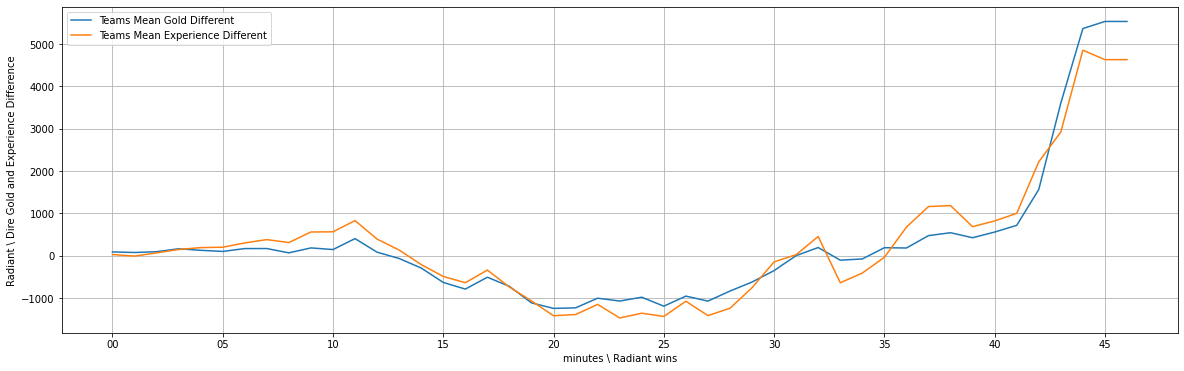

In [144]:
match_id = 26247
show_match(match_id)
# 26247 is a good showcase of match turnaround


### Visualizing the probablities of the Logistic Regression Model

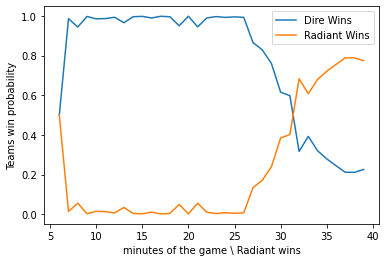

In [148]:
match = X_test.iloc[match_id:match_id+1, :]
probs = [model.predict_proba(match.iloc[:, i-6:i-1].dropna())[0] for model, i in models]

def get_prob_result(prob):
    return {
        'radiant_win_probability': prob[1],
        'dire_win_probability': prob[0]
    }

probs_arr = [get_prob_result(prob) for prob in probs]
probs_df = pd.DataFrame(probs_arr)

winner = 'Radiant' if does_win else 'Dire'
x_indexer = range(6, 40)
g1 = sns.lineplot(data=probs_df, y='dire_win_probability', x=x_indexer, label='Dire Wins')
g2 = sns.lineplot(data=probs_df, y='radiant_win_probability', x=x_indexer, label='Radiant Wins')

g1.set(xlabel=f'minutes of the game \ {winner} wins', ylabel='Teams win probability');

#### We see that around the 32nd minute the game is turned and the Radiant team starts to lead

### Model Assesement (TODO)

## Conditional Markov chains model of bin transitions